# Image Classification with CNN

In [18]:
from nimrod.utils import set_seed
from nimrod.models.core import lr_finder, train_one_cycle

from hydra.utils import instantiate
from omegaconf import OmegaConf
from rich import print

%load_ext autoreload
%autoreload 2
set_seed()


Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

[14:16:31] INFO - Init ImageDataModule for mnist
[14:16:33] INFO - loading dataset mnist with args () from split train
[14:16:42] INFO - loading dataset mnist with args () from split test
[14:16:44] INFO - split train into train/val [0.8, 0.2]
[14:16:44] INFO - train: 48000 val: 12000, test: 10000


_target_: nimrod.image.datasets.ImageDataModule
name: mnist
data_dir: ../data/image
train_val_split:
- 0.8
- 0.2
batch_size: 512
num_workers: 0
pin_memory: true
persistent_workers: false
transforms:
  _target_: torchvision.transforms.Compose
  transforms:
  - _target_: torchvision.transforms.ToTensor
  - _target_: torchvision.transforms.Normalize
    mean:
    - 0.1307
    std:
    - 0.3081

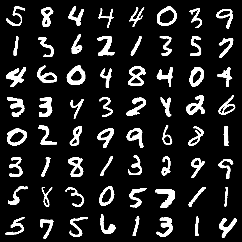

In [19]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 512
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(OmegaConf.to_yaml(cfg))
xb, yb = next(iter(dm.train_dataloader()))
dm.show_batch(xb[:64])

Seed set to 42
Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[15:51:58] INFO - ConvNetX: init
[15:51:58] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
[15:52:00] INFO - loading dataset mnist with args () from split train
[15:52:07] INFO - loading dataset mnist with args () from split test
[15:52:09] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[15:52:09] WARNING - no scheduler has been setup
/Users/slegroux/miniforge3/envs/n

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006309573444801936
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_c80122f2-52ec-4d9d-ace0-22735b5a7c12.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_c80122f2-52ec-4d9d-ace0-22735b5a7c12.ckpt


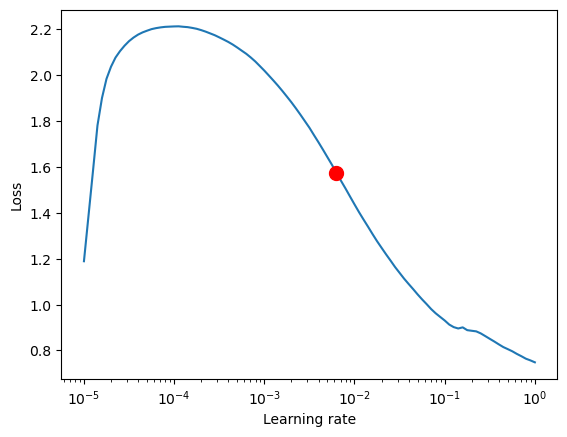

Suggested learning rate: 0.006309573444801936

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[15:52:21] INFO - ConvNetX: init
[15:52:21] INFO - Classifier: init


[15:52:22] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[15:52:22] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | ConvNet            | 44.8 K | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | train
8 | val_acc_best | MaxMetric          | 0      | train
------------------------------------------------------------
44.8 K    Trainable params
0         Non-trainable params
44.8 K    Total params
0.179     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9908000230789185     │
│         test/loss         │    0.02671484276652336    │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
lr-AdamW,▂▂▂▃▅▅▅▆▇▇▇▇█████████▇▇▆▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁
test/acc,▁
test/loss,▁
train/acc_epoch,▁▇███
train/acc_step,▁▄▄▆▆█▇█████████████████████████████████
train/loss_epoch,█▂▁▁▁
train/loss_step,█▆▅▄▄▃▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val/acc,▁▄▇██
val/acc_best,▁▄▇██


In [20]:
# SETUP

N_EPOCHS = 5
do_lr_finder = True

cfg_model = OmegaConf.load('../config/model/image/convnetx.yaml')
# feats_dim = [1, 8, 16, 32, 16]
# feats_dim = [1, 4, 8, 16, 8]
feats_dim = [1, 16, 32, 64, 32]
cfg_model.nnet.n_features = feats_dim
model = instantiate(cfg_model) #partial


# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 1e-4

# ONE-CYCLE TRAINING
train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name='MNIST-Classifier',
    tags=[f"feats:{feats_dim}", 'dev']
    )